## Category Development, Weak Supervision and CLassification
Today we are gonna practice the Discovery and Exploration steps involved in a Content Analysis project. 
And finally we are gonna look at the Implementation of baseline text classifiers as described in the ["baseline_classification.ipynb"](https://github.com/ulfaslak/sds_tddl_2020/blob/master/baseline_classification.ipynb) notebook. 

Overall you will learn how to
- setup a HSBM topic model within a docker environment (HSBM is unfortunatly hard to install)
- Practice Computer Assisted Query Building - ["Computer-Assisted Keyword and Document Set Discovery from Unstructured Text"](https://gking.harvard.edu/publications/computer-assisted-keyword-and-document-set-discovery-fromunstructured-text) and ["Building a Twitter opinion lexicon from automatically-annotated tweets"](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=1&cad=rja&uact=8&ved=2ahUKEwi4vabi56PoAhWEjqQKHUalAzEQFjAAegQIAxAB&url=https%3A%2F%2Fwww.sciencedirect.com%2Fscience%2Farticle%2Fpii%2FS095070511630106X&usg=AOvVaw11N9i8bUc2fwbbq9vLKsLY)
- Practice Weak Supervision techniques combining lexical appraoches with NLP parsing systems (Stanfordnlp).


Todays exercise will use the Kaggle Toxicity Classification dataset: https://www.kaggle.com/c/jigsaw-unintended-bias-in-toxicity-classification/data
- Follow the url. Sign in and download the zip file.

In [1]:
# load data
import pandas as pd
path2tox_data = '/home/snorre/Dropbox/Forskning/PhD/undervisning/train.csv'
df = pd.read_csv(path2tox_data)
# subsample data to allow faster prototyping
df = df.sample(5000)

In [2]:
df.head()

,id,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,...,article_id,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
440065,782588,0.7,I just don't get why soccer is so trendy in TO...,0.0,0.1,0.1,0.6,0.0,NaN,NaN,...,158034,approved,0,0,0,0,0,0.0,0,10
533788,896321,0.0,Excellent idea for Liberals to beg Artificial...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,...,164014,approved,0,0,0,3,0,0.0,0,4
880106,5197467,0.4,"And, your dear leader is a perfect human being...",0.0,0.0,0.0,0.4,0.0,0.0,0.0,...,330803,approved,0,0,0,0,5,0.0,10,10
4815,247452,0.0,If most people understood how unstable much of...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,42555,approved,0,0,0,0,0,0.0,4,4
814392,5117583,0.0,Waiting for it to come out that it was a regis...,0.0,0.0,0.0,0.0,0.0,NaN,NaN,...,325931,rejected,0,0,0,0,0,0.0,0,4


# Discovery

## Setting up HSBM
HSBM is based on the Network Package graph-tool which unfortunatly is notoriously hard to install on your ordinary laptops. 
For those of you using Linux, you can try installing on your own computer using similar commands as instructed in the Google Cloud example. 

Instead we have two possibilties: 
1. Create a local "server" on your own computer using Docker.
2. Use a Google Cloud server as introduced in Week 1 (see exercise 1 on how to setup Google Cloud).

### Docker solution
#### First Install docker (https://docs.docker.com/install/)
#### Enable file sharing.
Docker runs an operating system in a closed environment, so you have to create a port to share files. 

Go to the Docker settings: Right click the docker icon in press settings.
Press the /Ressources tab.
Then /File sharing tab.
Select the drive to be shared.

### Setup the Graph-tool docker image used for HSBM.
#### pull the image.
`docker pull tiagopeixoto/graph-tool`

#### Run the image while mounting the drive to be shared. # first allow shared drives in settings of the docker app
#### run this.
`docker run -v c:\:/mnt/c -p 8888:8888 -p 6006:6006  --name graphtool -it -u root -w /home/root tiagopeixoto/graph-tool bash`
##### In this example it was a c\: directory that I shared. c:\  specified the path to the shared directory on the host (your computer), and /mnt/c refered to the path in the Docker container.
 
#### Run Jupyter notebook and navigate to port localhost://8888 in your browser
`jupyter notebook --ip 0.0.0.0 --allow-root`

#### When using it the second time use the following commands, to simple start and attach to the container.
`docker container start graphtool`

`docker attach graphtool`



## Google Cloud Solution
- Login to the server you set up in week 1. See these instructions for setting it up (https://course.fast.ai/start_gcp.html)
- Run the following conda commands:
    - ```conda config --add channels conda-forge
conda config --add channels ostrokach-forge
conda config --add channels pkgw-forge
conda install gtk3 pygobject graph-tool cairo```




## Exercise 7.1: Running a HSBM topic model.


In [1]:
# Open a New .ipynb and copy the following cell to download the TOPSBM tutorial created by the Authors of HSBM.
import requests
for filename in ['corpus.txt','titles.txt','sbmtm.py','TopSBM-tutorial.ipynb']:
    url = 'https://raw.githubusercontent.com/martingerlach/hSBM_Topicmodel/master/%s'%filename
    with open(filename,'w') as f:
        f.write(requests.get(url).text)
# Follow the Tutorial to test out the model.

### 7.1.extra: Run the HSBM model on the Toxicity Dataset.

In [6]:
import sbmtm
# prepare documents
import re
url_re = re.compile('(?:https?:://)?www.[^ ]+')
import nltk
tokenizer = nltk.tokenize.casual.TweetTokenizer()
def preprocess_doc(string,tokenizer=tokenizer.tokenize):
    "simple preprocessing function"
    doc = string.lower() # lowercase
    doc = url_re.sub('url',doc)
    doc = tokenizer(doc)
    return doc

df['doc'] = df.comment_text.apply(preprocess_doc).values
docs = df['doc']
# remove infrequent words.
from collections import Counter
cutoff = 5
c = Counter()
for doc in docs:
    c.update(Counter(doc))
vocab = c.most_common(25000)
vocab = set([w for w,count in vocab if count>5])
# remove words
docs = [[w for w in doc if w in vocab] for doc in docs]


In [8]:
model = sbmtm.sbmtm()
model.make_graph(docs,documents=['%d'%i for i in range(len(docs))])

In [9]:
model.fit()

In [393]:
model.topics()

/home/snorre/Dropbox/Undervisning/test_material/transferlearning/sbmtm.py:544: RuntimeWarning: invalid value encountered in true_divide
  p_td_d = (n_db/np.sum(n_db,axis=1)[:,np.newaxis]).T
/home/snorre/Dropbox/Undervisning/test_material/transferlearning/sbmtm.py:550: RuntimeWarning: invalid value encountered in true_divide
  p_tw_d = (n_dbw/np.sum(n_dbw,axis=1)[:,np.newaxis]).T


{0: [('i', 0.6180613090306545),
  ('my', 0.1164043082021541),
  ('me', 0.07187241093620547),
  ("'m", 0.048260149130074564),
  ('am', 0.03707539353769677),
  ("'ve", 0.03210439105219553),
  ("'ll", 0.025890637945318973),
  ('family', 0.025062137531068767),
  ('guess', 0.01284175642087821),
  ('seen', 0.012427506213753107)],
 1: [("n't", 0.041525254541824715),
  ('do', 0.036309642643242164),
  ('what', 0.027575364344180474),
  ('about', 0.019739468955879417),
  ('just', 0.01736873627470553),
  ('like', 0.01736873627470553),
  ('when', 0.016270712717109205),
  ('out', 0.01584647634258335),
  ('how', 0.014773407865841486),
  ('did', 0.012752046316630065)],
 2: [('for', 0.0878066964890877),
  ('are', 0.07048935881794767),
  ('have', 0.06096651755456148),
  ('be', 0.06049206994713298),
  ('they', 0.05761149518774569),
  ('will', 0.03788803036464688),
  ('we', 0.03768469567574895),
  ('if', 0.03561745967195337),
  ('would', 0.032499661108851836),
  ('their', 0.03209299173105599)],
 3: [('you

## Exercise 7.2: Computer-Assisted Category Development
First you need to install the [Gensim package](https://radimrehurek.com/gensim/)

The package implements a range of unsupervised text methods, including classic topic modelling like LDA, Wordembeding models like Word2Vec and GloVe,  and an implementation of one of the early Paragraph Embedder "Doc2Cec". The package furthermore comes with a set of pretrained models that can be used for wordbased similarity search.

In this exercise you will practice using pretrained Word Embeddings for similarity search.


- Load a model from the Gensim (if not installed `! conda install -c anaconda gensim`) [pretrained models](https://github.com/RaRe-Technologies/gensim-data)
    - I suggest you use the `"glove-wiki-gigaword-300"` model.

```## Load gensim model
import gensim
import gensim.downloader as api
glove = api.load("glove-wiki-gigaword-300")```

- Play around with the `most_similar()` function of the model.
    - Try defining both the `positive=` and `negative=` argument of the function. 

## Build a lexicon from scratch
- Inspect 5-10 documents in the dataset to create an Initial list of positive and negative words, or come up with a topic yourself (e.g. politics).
- Create an input function for evaluating new words.
    - Use the model.get_similar(word) function to get candidate words.
    - Run through the candidates.
    - print the word to be evaluated.
    - use the builtin method `input()` to get manual input.
    - use the input to either save or discard candidate words.
    - repeat process until you have >20 words.
- Apply a lookup function to the dataset.
    - First you tokenize the data using a tokenizer of choice. I suggest nltk.tokenize.casual.TweetTokenizer()
    - create a function that loops through the words and counts matching with your lexicon.
Extra: Train your own word2vec model on the Full toxicity dataset.

In [44]:
## Load gensim model
import gensim
import gensim.downloader as api
glove = api.load("glove-wiki-gigaword-300")


[=======-------------------------------------------] 14.3% 53.8/376.1MB downloaded

In [390]:
glove.most_similar(positive=['police','black'],negative=['white'])[0:5]


[('officers', 0.6411764621734619),
 ('policemen', 0.6110767722129822),
 ('arrested', 0.5419429540634155),
 ('policeman', 0.5184690952301025),
 ('authorities', 0.5138450264930725)]

In [392]:
glove.most_similar(positive=['police','white'],negative=['black'])[0:5]

[('officers', 0.6044589877128601),
 ('officials', 0.5710611343383789),
 ('authorities', 0.554427981376648),
 ('investigators', 0.5223734378814697),
 ('arrest', 0.5114766359329224)]

In [402]:
seeds = ['policy','trump','president','liberals','republican','democrats']
lexicon = []
done = set()

In [403]:
glove.most_similar('policy')

[('policies', 0.8036329746246338),
 ('strategy', 0.6325587034225464),
 ('stance', 0.5960066318511963),
 ('administration', 0.5948634147644043),
 ('economic', 0.5877833366394043),
 ('reform', 0.5807735919952393),
 ('change', 0.578568160533905),
 ('decisions', 0.5783397555351257),
 ('monetary', 0.5625898241996765),
 ('agenda', 0.5607941746711731)]

In [405]:
while len(seeds)>0:
    seed = seeds.pop(0)
    if seed in glove.vocab:
        similar = glove.most_similar(seed)
    else:
        done.add(seed)
        lexicon.append(seed)
        continue
    for candidate,score in similar:
        print()
        print(candidate,score)
        i = input('Include in lexicon? PRess y else enter')
        if i=='y':
            seeds.append(candidate)
    if len(done)%10==0:
        end = input('Do you wish to continue? Press Enter else n')
        if end=='n':
            break
        


ivana 0.49990522861480713


Include in lexicon? PRess y else enter y



melania 0.45651504397392273


Include in lexicon? PRess y else enter 



casino 0.45222747325897217


Include in lexicon? PRess y else enter 



nows 0.44631344079971313


Include in lexicon? PRess y else enter 



knauss 0.436074823141098


Include in lexicon? PRess y else enter 



hilton 0.4234514832496643


Include in lexicon? PRess y else enter 



trumps 0.4143375754356384


Include in lexicon? PRess y else enter y



ivanka 0.40609344840049744


Include in lexicon? PRess y else enter y



resorts 0.3992827236652374


Include in lexicon? PRess y else enter 



wynn 0.3902420997619629


Include in lexicon? PRess y else enter 
Do you wish to continue? Press Enter else n y



vice 0.7302780747413635


Include in lexicon? PRess y else enter 



presidents 0.6492104530334473


Include in lexicon? PRess y else enter y



presidency 0.5860213041305542


Include in lexicon? PRess y else enter y



presidential 0.5705326795578003


Include in lexicon? PRess y else enter y



bush 0.5581309795379639


Include in lexicon? PRess y else enter y



clinton 0.5491981506347656


Include in lexicon? PRess y else enter y



elect 0.5369746685028076


Include in lexicon? PRess y else enter y



elected 0.525804877281189


Include in lexicon? PRess y else enter y



w. 0.5164961814880371


Include in lexicon? PRess y else enter 



inauguration 0.4999786615371704


Include in lexicon? PRess y else enter 
Do you wish to continue? Press Enter else n y



conservatives 0.8324412107467651


Include in lexicon? PRess y else enter y



liberal 0.7376298904418945


Include in lexicon? PRess y else enter y



democrats 0.678396463394165


Include in lexicon? PRess y else enter y



socialists 0.6549149751663208


Include in lexicon? PRess y else enter y



conservative 0.6484119892120361


Include in lexicon? PRess y else enter y



progressives 0.6397043466567993


Include in lexicon? PRess y else enter y



tories 0.6257392168045044


Include in lexicon? PRess y else enter 



reformers 0.6107094883918762


Include in lexicon? PRess y else enter y



moderates 0.6034201979637146


Include in lexicon? PRess y else enter y



republicans 0.5922455191612244


Include in lexicon? PRess y else enter y
Do you wish to continue? Press Enter else n n


In [ ]:
#Extra train a word2vec model from scratch
# run w2vec.
import gensim
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
from gensim.models.word2vec import Word2Vec
############
## missing
#####load pretrained and just retrain
###############
### Define parameters for the model ###
size=300 # Size of Embedding.
workers=4 # Number CPU Cores to use for training in Parallel.
iter_= 50 # Depending on the size of your data you might want to run through your data more than once.
window=6 # How much Context
min_count=5 # Number of Occurrences to be kept in the Vocabulary
### Initialize model and start training ###
count = 0
ws = Counter()
for i in docs:
    count+=len(i)
    for w in i:
        ws[w]+=1
print('%d unique words in corpus and %d count'%(len(ws),count))
max_words = 250000
ws = dict(ws.most_common(max_words))
min_words = 200000000

iter_ = min_words//count
iter_ = max(iter_,2)
w2v = Word2Vec(size=size,workers=workers,negative=10,iter=0,window=window,min_count=min_count) # max_final_vocab = max_words
w2v.build_vocab_from_freq(ws)

print('Getting ready to train')
print(w2v.corpus_count)
for i in range(iter_):
    w2v.train(docs,total_words = count,epochs=1)

## 7.3: Weak supervision combining sentiment lexicon and dependency parser.
This exercise we will create a weak supervision scheme, that combines the Vader sentiment analysis tool implemented in the nltk package, with a nlp parser to extract relationships - i.e. who is the negative sentiment directed against.

First install the stanza package(`! pip install stanza`), formerly known as stanfordnlp.

The package supports a [multitude of languages](https://stanfordnlp.github.io/stanza/models.html), but each model should be downloaded first using the `stanza.download()` function. Here we need to download the english one: `stanza.download('en')`.

1.import nltk.sentiment and initialize the vader sentiment analyzer.

2. Apply the vader sentiment analyzer extracting only the 'neg' value, and plot the results in relation to the columns: `['black','female','asian','homosexual_gay_or_lesbian']` as a barchart. The columns express the social groups involved/addressed in the comment. 

3. Make a column in the dataset that expresses whether 'woman' + relevant synonyms found using the Glove model, is mentioned in the text.

4. Compute the precision and recall of the woman identifier in relation to the 'female' column.

In [343]:
import nltk.sentiment
vader = nltk.sentiment.vader.SentimentIntensityAnalyzer()



{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}

In [344]:
df['vader_sentiment'] = df.comment_text.apply(lambda x: vader.polarity_scores(x)['neg'])

In [346]:
y = []
for col in ['black','female','asian','homosexual_gay_or_lesbian']:
    y.append(df[df[col]>0]['vader_sentiment'].mean())
    

<BarContainer object of 4 artists>

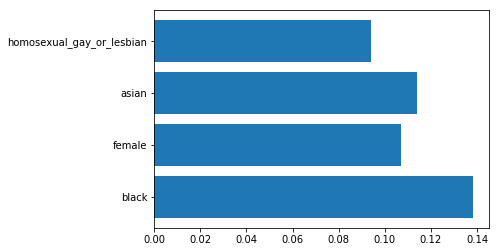

In [350]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.barh(['black','female','asian','homosexual_gay_or_lesbian'],y)

In [337]:
print(glove.most_similar('woman',topn=15)) # glove
women_s = set(['woman','girl','mother','she','her','women','herself','wife','daughter'])

df['women_match'] = df.doc.apply(lambda x: len(set(x)&women_s)>0)

[('girl', 0.7296419143676758), ('man', 0.6998662948608398), ('mother', 0.689943790435791), ('she', 0.6433226466178894), ('her', 0.6327143311500549), ('female', 0.6251603960990906), ('herself', 0.6215280294418335), ('person', 0.6170896887779236), ('women', 0.604761004447937), ('wife', 0.5986992120742798), ('daughter', 0.5714551210403442), ('pregnant', 0.5604141354560852), ('victim', 0.5527148246765137), ('husband', 0.5462620258331299), ('boy', 0.5453975200653076)]


In [357]:
import sklearn.metrics
sklearn.metrics.recall_score(df.women_match.astype(int),(df.female>0).astype(int)),sklearn.metrics.precision_score(df.women_match.astype(int),(df.female>0).astype(int))


(0.3927710843373494, 0.7990196078431373)

## Stanfordnlp to match adjectives and women.

5. Run the nlp pipeline by initializing the parser `stanza.Pipeline('en').

6. Transform the Parse object to a list of sentences using the function `nlp_to_dict`.
    - This will return a list of sentences, which by themselves are lsit of words including the parsed properties such as Word class.  

7. Now we should get acquinted with the information involved. Count the most common lemmas of each wordclass(i.e. the 'upos' property), and print the top 10 words.

8. Apply the `extract_adj_noun()` that returns a dataframe of noun-adjective pairs. 

9. Keep only rows where "women" + synonmyms is found in the noun column.

10. Inspect the adjectives used, and compute which are significantly more common using the *Chi Squared measure*:

$Chi^2$ express the difference between the co-occurence we observe and what we would have expected to see if two events independent, relative to the latter. I.e. how many times more prevalent is the co-occurrence we observe than what we would expect if they were independent.

$X^{2}=\sum_{i, j} \frac{\left(O_{i j}-E_{i j}\right)^{2}}{E_{i j}}$
where $i$ ranges over rows of the table, $j$ ranges over columns, $O_{i j}$ is the observed value for cell ($i,j$) and $E_ij$ is the expected value.
 

11. Match the adjectives to two positive and negative word lists precompilled in the NLTK package. 
```
from nltk.corpus import opinion_lexicon
positive_w = set(opinion_lexicon.positive())
negative_w = set(opinion_lexicon.negative())
```
12. Finally wrap this into a function, that returns true if both women+synonyms is present, and a negative word.



In [22]:
import stanza

In [26]:
stanza.download('en') # download English model
nlp = stanza.Pipeline('en') # initialize English neural pipeline

2020-03-18 20:06:15 INFO: Downloading default packages for language: en (English)...
2020-03-18 20:07:16 INFO: Finished downloading models and saved to /home/snorre/stanza_resources.
2020-03-18 20:07:16 INFO: Loading these models for language: en (English):
| Processor | Package   |
-------------------------
| tokenize  | ewt       |
| pos       | ewt       |
| lemma     | ewt       |
| depparse  | ewt       |
| ner       | ontonotes |

2020-03-18 20:07:17 INFO: Use device: cpu
2020-03-18 20:07:17 INFO: Loading: tokenize
2020-03-18 20:07:17 INFO: Loading: pos
2020-03-18 20:07:18 INFO: Loading: lemma
2020-03-18 20:07:18 INFO: Loading: depparse
2020-03-18 20:07:19 INFO: Loading: ner
2020-03-18 20:07:19 INFO: Done loading processors!


In [27]:
df['nlp'] = df.comment_text.apply(nlp)

In [287]:
def nlp_to_dict(doc,keep_sentence=True):
    dependencies = []

    if keep_sentence == True:
        for sent in doc.sentences:
            #keys = [i for i in dir(sent.words[0]) if '_' !=i[0] and i!='misc']
            temp = []
            for word in sent.words:
                d = word.to_dict()
                #d = {key:getattr(word,key) for key in keys}
                d['index'] = int(d['id'])
                temp.append(d)
            dependencies.append(temp)
    else:
        max_id = 0
        for sent in doc.sentences:
            keys = [i for i in dir(sent.words[0]) if '_' !=i[0] and i!='misc']
            words = sent.words
            
            for word in words:
                d = word.to_dict()
                #d = {key:getattr(word,key) for keyn in keys}
                d['index'] = int(d['id'])
                dependencies.append(d)
    return dependencies
df['nlp_parse'] = df.nlp.apply(nlp_to_dict)

In [292]:
typ2common = {}
for d in df.nlp_parse.values:
    

    for l in d:
        for i in l: 
            typ=i['upos']
            if not typ in typ2common:
                typ2common[typ] = Counter()
            
            c = typ2common[typ]
            c[i['lemma']]+=1

In [295]:
sort_types = sorted(typ2common,key=lambda x:sum(typ2common[x].values()),reverse=True )
for typ in sort_types:
    c = typ2common[typ]
    print(typ,c.most_common(10))

NOUN [('people', 879), ('year', 545), ('time', 509), ('tax', 361), ('way', 346), ('government', 344), ('thing', 302), ('state', 285), ('country', 284), ('money', 256)]
PUNCT [('.', 13996), (',', 9549), ('"', 3423), ('?', 1936), ('-', 1450), (')', 753), ('(', 730), ('!', 678), ('...', 599), ("'", 496)]
VERB [('have', 1659), ('be', 1028), ('do', 907), ('get', 716), ('make', 711), ('go', 679), ('say', 638), ('think', 567), ('know', 511), ('see', 489)]
PRON [('you', 3758), ('I', 3319), ('they', 3201), ('it', 3160), ('he', 2275), ('we', 1978), ('that', 1799), ('who', 962), ('what', 927), ('this', 770)]
ADP [('of', 5293), ('in', 3745), ('for', 2362), ('to', 2252), ('with', 1615), ('on', 1505), ('by', 869), ('from', 853), ('as', 710), ('at', 674)]
DET [('the', 12788), ('a', 6254), ('this', 934), ('all', 920), ('no', 683), ('any', 469), ('some', 452), ('that', 407), ('these', 311), ('those', 227)]
ADJ [('more', 474), ('many', 432), ('other', 430), ('good', 401), ('same', 241), ('own', 193), ('

In [147]:
def extract_adj(d):
    
    i2d = {}#i['id']:i for i in d}
    for l in d:
        for i in l:
            i2d[i['id']] = i
    pairs = []
    for l in d:
        for i in l:
            if i['upos'] == 'ADJ':
                head = i['head']
                if head==0:
                    continue
                pairs.append((i,i2d[str(head)]))
    dat = []
    for i,j in pairs:
        d = {}
        for col in ['text','lemma']:
            d['adj_%s'%col] = i[col]
            d['obj_%s'%col] = j[col]
            
        dat.append(d)
    return pd.DataFrame(dat)

In [106]:
import networkx as nx

def get_subject_verb_object(doc):
    "Input should be a dependency parsed document"
    keep_types = set(['VERB','NOUN','ADJ','PROPN','ADV'])
    relations = []

    for num,sent in enumerate(doc):
        subjects = []
        objects = []
        subject_verb_object = nx.DiGraph()
        for w in sent:
            typ = w['upos']
            if not typ in keep_types:
                continue
            meta = {key:w[key] for key in ['upos','head','index','lemma','text','deprel']}
            parent = w['head']
            i = w['index']
            rel = w['deprel']
            if 'obl' in rel:
                objects.append(i)
            if 'nsubj' in rel:
                subjects.append(i)
            lemma = w['lemma']
            text = w['text']
            subject_verb_object.add_node(i,**meta)
            subject_verb_object.node[i]['index'] = i
            if parent!=0:
                subject_verb_object.add_edge(i,parent)
        # parse graph. 

        for i in subjects:
            neighbors = subject_verb_object[i]
            subj_d = subject_verb_object.node[i]
            subj_meta = {'subj_'+i:subj_d[i] for i in ['index','lemma','text','deprel']}
            pairs = []
            for n in neighbors:

                verb_d = subject_verb_object.node[n]
                if len(verb_d)==0:
                    continue
                
                verb_meta = {'verb_'+i:verb_d[i] for i in ['index','lemma','text','deprel']}
                
                verb_meta['ADJ'] = []
                verb_meta['ADV'] = []
                for n1,_ in subject_verb_object.in_edges(n):
                    d = subject_verb_object.node[n1]
                    rel = d['deprel']
                    if 'obl' in rel:
                        obl_meta = {'obl_'+i:d[i] for i in ['index','lemma','text','deprel']}
                        verb_meta.update(obl_meta)
                    else:
                        typ = d['upos']
                        if typ in verb_meta:
                            verb_meta[typ].append({i:d[i] for i in ['index','lemma','text','deprel']})
                d = subj_meta.copy()
                d.update(verb_meta)
                d['sent_num'] = num
                relations.append(d)
    return pd.DataFrame(relations)

In [198]:
d = nlp_to_dict(doc)

In [362]:
def make_network(d):
    i2d = {}
    g = nx.Graph()
    for num,l in enumerate(d): 
        for i in l:
            id_ = '%d_%d'%(num,int(i['id']))
            i2d[id_] = i
            parent = i['head'] 
            
            if parent==0:
                continue
            parent = '%d_%d'%(num,parent)
            g.add_edge(id_,parent)
    # make full network
    for i in g:
        for j in g[i]:
            for k in g[i]:
                g.add_edge(j,k)
    return g,i2d
def extract_adj_noun(d):
    g,i2d = make_network(d)
    temp = []
    for i in i2d:
        d = i2d[i]
        type = d['upos']
        text_a,lemma_a = d['text'],d['lemma']
        if type=='ADJ':
            if not i in g:
                continue
            for n in g[i]:
                if i2d[n]['upos'] == 'NOUN':
                    d = i2d[n]
                    text,lemma = d['text'],d['lemma']
                    temp.append({'adj_text':text_a,'adj_lemma':lemma_a,'noun_text':text,'noun_lemma':lemma})
    return pd.DataFrame(temp)
adjnoun_df = extract_adj_noun(sample.nlp_parse.values[0])

In [385]:
temp = []
for doc in df.nlp_parse:
    adjnoun_df = extract_adj_noun(doc)
    temp.append(adjnoun_df)
adjnoun_df = pd.concat(temp,sort=False)

In [410]:
adjnoun_df['woman'] = adjnoun_df.noun_text.isin(women_s)

In [386]:
women_adj = adjnoun_df[adjnoun_df.noun_text.isin(women_s)]

In [412]:
counts = adjnoun_df.groupby('woman')['adj_text'].value_counts()

In [416]:
all_counts = adjnoun_df.adj_text.value_counts()
N = all_counts.sum()

In [424]:
neg = counts[False]
pos = counts[True]
perc = sum_pos/N
exp = all_counts*perc
obs = pos[all_counts.index].fillna(0)
chi = ((obs-exp)**2)/exp
## get direction
sign = obs-exp
chi_sign = chi*sign

In [426]:
chi_sign.sort_values().head()

good     -10.288531
public   -10.157001
social    -6.689322
free      -6.061369
legal     -4.108758
Name: adj_text, dtype: float64

In [427]:
chi_sign.sort_values().tail()

accountable    371.710371
feminist       381.770324
sexual         397.264136
white          455.760422
young          986.174920
Name: adj_text, dtype: float64

In [372]:
from nltk.corpus import opinion_lexicon
positive_w = set(opinion_lexicon.positive())
negative_w = set(opinion_lexicon.negative())
women_adj[women_adj.adj_text.isin(negative_w)]

,adj_lemma,adj_text,noun_lemma,noun_text
8,disgusting,disgusting,woman,women
46,afraid,afraid,girl,girl
1,irrelevant,irrelevant,woman,women
19,partisan,partisan,woman,women
18,negligent,negligent,wife,wife
82,authoritarian,authoritarian,woman,women
87,authoritarian,authoritarian,woman,women
91,lame,lame,woman,woman
84,ridiculous,ridiculous,woman,women
14,primitive,primitive,woman,women


In [378]:
def woman_negative(row):
    nlp_parse = row['nlp_parse']
    doc = row['doc']
    women_in = len(set(doc)&women_s)>0
    if not women_in:
        return 0
    adjnoun_df = extract_adj_noun(nlp_parse)
    if len(adjnoun_df)==0:
        return 0
    
    women_adj = adjnoun_df[adjnoun_df.noun_text.isin(women_s)]
    if len(women_adj)==0:
        return 0
    score = len(women_adj[women_adj.adj_text.isin(negative_w)])
    return score
df['women_negative'] = df.apply(woman_negative,axis=1)

In [384]:
df.groupby('women_negative').apply(lambda x: (x.female*x.target).mean())

women_negative
0    0.016757
1    0.163716
2    0.173611
3    0.150000
4    0.000000
dtype: float64

# 7.4 Compiling the lexicons. 
- Here you should follow the instructions from the lexical_methods.ipynb notebook of compilling and downloading the lexicons. 
- Alternatively you can download the precompilled lexicon functions that the notebook builds using the link supplied on absalon. 
- download the lexical_mining.py script that wraps around all individual lexicon functions.
- import and appy the lexical_mining script using the `.lexical_mining()` function to the toxicity_dataset.
- Compare the different variables in relation to the Groups: `['black','female','asian','homosexual_gay_or_lesbian']` and see if the different sentiment analytical methods agree on which group is recieving most hostility.
    - Do this by computing the mean of the different sentiment variables: `['vader_neg','afinn_afinn','liu_negative_count','hedometer_happiness']` in relation to each group. 
    - Then compare the ranking made by each sentiment variable.

In [40]:
import lexical_mining as lex
lex_df = df.comment_text.apply(lex.lexical_mining)


In [166]:
for col in ['black','female','asian','homosexual_gay_or_lesbian','conglomerate_sentiment_negative']:
    lex_df[col] = df[col]

In [191]:
neg_cols = ['vader_neg','afinn_afinn','liu_negative_count','hedometer_happiness']
temp = []

    
for meta_col in ['black','female','asian','homosexual_gay_or_lesbian']:
    d = lex_df[lex_df[meta_col]>0].mean()[neg_cols]
    d = pd.DataFrame(d).T
    d.index = [meta_col]
    
    temp.append(d)
    
    
sent_df = pd.concat(temp)

In [193]:
for col in sent_df.columns:
    print(col,sent_df.sort_values(col).index)

vader_neg Index(['homosexual_gay_or_lesbian', 'female', 'asian', 'black'], dtype='object')
afinn_afinn Index(['black', 'asian', 'homosexual_gay_or_lesbian', 'female'], dtype='object')
liu_negative_count Index(['homosexual_gay_or_lesbian', 'female', 'asian', 'black'], dtype='object')
hedometer_happiness Index(['black', 'asian', 'homosexual_gay_or_lesbian', 'female'], dtype='object')
